In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Torch 
import torch
import torch.nn as nn
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader

# Scikit-Learn
# Data Encoding and Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Natural Language Processing(NLP)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Word Embedding
import gensim
from gensim.models import Word2Vec

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
df = pd.read_csv('IntervieweeDataset.csv')

In [4]:
df.shape

(21256, 52)

In [5]:
df.columns

Index(['Name', 'Age', 'Gender', 'Type of Graduation/Post Graduation',
       'Marital status', 'Mode of interview given by candidate?',
       'Pre Interview Check', 'Fluency in English based on introduction',
       'Confidence based on Introduction (English)',
       'Confidence based on the topic given  ',
       'Confidence Based on the PPT Question',
       'Confidence based on the sales scenario',
       'Structured Thinking (In regional only)',
       'Structured Thinking Based on the PPT Question',
       'Structured Thinking( Call pitch)',
       'Regional fluency based on the topic given  ',
       'Regional fluency Based on the PPT Question',
       'Regional fluency based on the  sales scenario',
       'Does the candidate has mother tongue influence while speaking english.',
       'Has acquaintance in Company and has spoken to him/her before applying?',
       'Candidate Status', 'Last Fixed CTC (lakhs) ', 'Currently Employed',
       'Experienced candidate - (Experience 

## Dropped Columns

In [7]:
df.dropna(inplace=True)

In [8]:
df.drop(df.iloc[:,8:18], axis=1, inplace=True)

In [9]:
df.drop(['Does the candidate has mother tongue influence while speaking english.',
         'How many slides candidate have submitted in PPT?',
        'Comments',
        'RedFlags Comments in Interview',
        'Call-pitch Elements used during the call Sales Scenario',
        "But, my child's exam are going on now, so we will keep the counselling session after the exams get over.(Time: Favourable pitch: Counsellor hype)",
        'Let me discuss it with my child',
        "Sir being in education industry I know this is a marketing gimmick and at the end of the day you'll be selling the app."], axis=1, inplace=True)

## Renamed Columns

In [11]:
df.rename(columns={'Whether joined the company or not\n': 'Whether joined the company or not', 'What was the type of Role?\t': 'What was the type of Role?'}, inplace=True)

In [12]:
df.rename(columns={"But, my child's exam are going on now, so we will keep the counselling session after the exams get over.(Time: Favourable pitch: Counsellor hype)":"But, my child's exam are going on now, so we will keep the counselling session after the exams get over"}, inplace=True)

In [13]:
df.rename(columns = {'Has acquaintance in Company and has spoken to him/her before applying?' : 'Acquaintance and Referral'}, inplace=True)

In [14]:
df.rename(columns = {'Type of Graduation/Post Graduation' : 'Education'}, inplace=True)

In [15]:
df.rename(columns= {'Mode of interview given by candidate?' : 'Mode of Interview'}, inplace=True)

In [16]:
df['id'] = df.index

In [17]:
df['Whether joined the company or not'] = df['Whether joined the company or not'].replace({'Joined':'Yes', 'Not Joined':'No'})
df['Whether joined the company or not'] = df['Whether joined the company or not'].map({'Yes': 1, 'No': 0}).astype(int)

In [18]:
df.columns

Index(['Name', 'Age', 'Gender', 'Education', 'Marital status',
       'Mode of Interview', 'Pre Interview Check',
       'Fluency in English based on introduction', 'Acquaintance and Referral',
       'Candidate Status', 'Last Fixed CTC (lakhs) ', 'Currently Employed',
       'Experienced candidate - (Experience in months)',
       'Experienced Candidate (Nature of work)', 'What was the type of Role?',
       'Call-pitch Elements used during the call Sales Scenario',
       'But, my child's exam are going on now, so we will keep the counselling session after the exams get over',
       'Let me discuss it with my child',
       'Sir being in education industry I know this is a marketing gimmick and at the end of the day you'll be selling the app.',
       'Role acceptance', 'Interview Verdict',
       'Candidate is willing to relocate',
       'Role Location to be given to the candidate', 'Comments',
       'RedFlags Comments in Interview',
       'Confidence based on Introduction (Engl

In [19]:
education_mapping = {
    'Engineering & Technology': [
        'B.E / B-Tech', 'M.E / M-Tech', 'B-Tech - INTEGRATED', 'BE - CSe and CDAC',
        'B.ENG', 'Bachelors of planning', 'B.Arch', 'Bachelor of Architecture', 'B.ARC'
    ],
    'Science & Medical': [
        'BSc or MSc', 'BSC', 'MS', 'Masters in biotechnology', 'PG - msc biochemistry',
        'Bio science', 'masters in biology', 'biotech', 'Masters of Statistics',
        'Bachelors in biotechnology', 'Ph D genetics', 'MBBS', 'Bachelor in medical lab',
        'B.Physiotherapist', 'B.pharma', 'M.pharma', 'B -pharm', 'B.PHARMA',
        'PHARMA D', 'pharm D', 'M.Pharma', 'Bachelors in dental',
        'Masters in Clinical Psychology', 'B.voc in applied clinical psychology'
    ],
    'Commerce & Business': [
        'B.com', 'BCOM COMPUTERS', 'Bcom computers', 'bcom -pa', 'M.com',
        'MBA', 'MBA- 2019', 'MBA agro business', 'PGDM', 'pgdm', 'PGDM 2022',
        'PGDM marketing', 'PG diploma in banking', 'PG DIPLOMA IN BANKING',
        'Masters in banking and insurance', 'BBA or BBM', 'BBM',
        'Bachelor of Business Economics (B.B.E.)', 'PGPM', 'PGPM in marketing',
        'PGPCEM', 'PGDBS', 'B.Voc - Banking & Finance'
    ],
    'Humanities & Social Sciences': [
        'BA/MA', 'LLB', 'LLM', 'MPhil', 'M.phil', 'Mphil 2020', 'PHD', 'doctorate',
        'Masters of Social Work (MSW)', 'msw', 'msw-hr-2014', 'MSW HRM',
        'Public administration', 'Masters in comparative religion', 'Masters in archeology',
        'English Honors', 'MASTERS IN SOCIAL SCIENCE', 'Bengali Honors'
    ],
    'Mass Communication & Media': [
        'B.comm (Bachelor of mass comm.)', 'Bachelor mass communication',
        'mass media', 'masss media', 'mass comm', 'Mass comm', 'BMM ( MAss Media)',
        'BJMC', 'MJMC 2020', 'Masters in mass communication', 'MASTERS IN MASS COM',
        'Masters in Convergent Journalism', 'master maas comm', 'master in electronic media'
    ],
    'Vocational & Professional Courses': [
        'B.ed (Teaching)', 'B.ed', 'B.ED', 'M.ed', 'D.el.ed', 'd el. ed', 'Dled',
        'Bachelors in fisheries science', 'Bachelors in tourism', 'Bachelor of Tourism',
        'travel & toursim', 'Bachelors in design', 'B.Design', 'Bachelors in hospitality',
        "Bachelor's in Hospitality", 'Hotel Management', 'Masters in fashion designing',
        'Masters in hospitality', 'Masters in design', 'food technology',
        'BVoc', 'B.VOC', 'B.vocational', 'B.voc - IT', 'B.voc networking and mobile applications',
        'bachelors of vocational - automobile', 'Bpharma', 'Mpharma', 'Diploma', 'Diploma in engr',
        'PGDCA', 'PGD', 'pgdca', 'PGD (Bachelor of Library Science)', 'BMIT',
        'PGDF', 'PGDA', 'MFC', 'MLIS', 'BMS', 'BMS marketing', 'bms', 'bms-2020',
        'Bachelor in IT', 'BCA/MCA', 'CSE', 'PDGM Advance Computing'
    ]
}

# Function to map education to categories
def categorize_education(education):
    for category, degrees in education_mapping.items():
        if education in degrees:
            return category
    return 'Other'  # Default category if not found

## Numerical Dataframe

In [21]:
numerical_df = df.copy()
numerical_df.drop(['id',
                   'Name',
                   'Comments',
                   'RedFlags Comments in Interview',
        'Whether joined the company or not',
        'Experienced Candidate (Nature of work)',
        'Call-pitch Elements used during the call Sales Scenario',
        "But, my child's exam are going on now, so we will keep the counselling session after the exams get over",
        'Let me discuss it with my child',
        "Sir being in education industry I know this is a marketing gimmick and at the end of the day you'll be selling the app."], axis=1, inplace=True)

df = df[['id',
         'Name',
         'Comments',
         'RedFlags Comments in Interview',
         'Whether joined the company or not',
         'Experienced Candidate (Nature of work)',
         'Call-pitch Elements used during the call Sales Scenario',
         "But, my child's exam are going on now, so we will keep the counselling session after the exams get over",
         'Let me discuss it with my child',
         "Sir being in education industry I know this is a marketing gimmick and at the end of the day you'll be selling the app."]]

In [22]:
numerical_df['Age'] = numerical_df['Age'].astype(str).str.replace('+', '', regex=False).astype(int)

In [23]:
numerical_df['Education'] = numerical_df['Education'].apply(categorize_education)

In [24]:
numerical_df['Education'].unique()

array(['Other', 'Science & Medical', 'Engineering & Technology',
       'Humanities & Social Sciences', 'Commerce & Business',
       'Vocational & Professional Courses', 'Mass Communication & Media'],
      dtype=object)

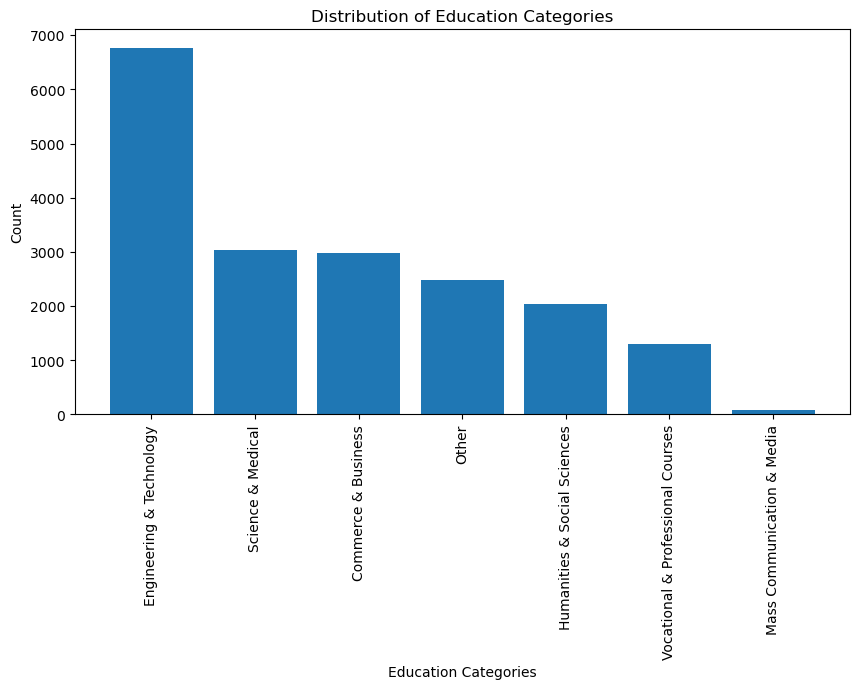

In [25]:
education_counts = numerical_df['Education'].value_counts()
plt.figure(figsize=(10, 5))
plt.bar(education_counts.index, education_counts.values)
plt.xticks(rotation=90)  
plt.xlabel("Education Categories")
plt.ylabel("Count")
plt.title("Distribution of Education Categories")
plt.show()

In [26]:
bins = [18, 22, 25, 28, 32, 35, float('inf')]
labels = ['18-22', '23-25', '26-28', '29-32', '33-35', '35+']

In [27]:
numerical_df['Age'] = pd.cut(numerical_df['Age'], bins=bins, labels=labels, right=True)

In [28]:
numerical_df['Age'].unique()

['23-25', '29-32', '26-28', '18-22']
Categories (6, object): ['18-22' < '23-25' < '26-28' < '29-32' < '33-35' < '35+']

In [29]:
numerical_df['Role Location to be given to the candidate'] = numerical_df['Role Location to be given to the candidate'].replace({'Inbound Bangalore':'Bangalore ', 'Bangalore ':'Bangalore'})

In [30]:
numerical_df['Role Location to be given to the candidate'].unique()

array(['Bangalore', 'Delhi ', 'Chennai ', 'Pune ', 'Kolkata ', 'Indore ',
       'Hyderabad ', 'Bangalore ', 'Coimbator ', 'Shimoga ', 'Shivamoga ',
       'Ranchi ', 'Karnal ', 'Bhagalpur ', 'Coimbatore ', 'Muzaffarpur ',
       'Nagpur ', 'Bareilly ', 'Mangalore ', 'Surat ', 'Bengaluru ',
       'Kanpur ', 'Dhanbad ', 'Bellary ', 'Kollam ', 'Gaya ',
       'Ghaziabad ', 'Kochi ', 'Thrissur ', 'Patna ', 'Agra ',
       'Ahmedabad ', 'Noida ', 'Gurgaon ', 'Anand ', 'Cuttack ',
       'Saharanpur ', 'Bikaner ', 'Salem ', 'Jaipur ', 'Bhubaneswar ',
       'Udaipur ', 'Lucknow ', 'Rewa ', 'Gwalior ', 'Kurnool ', 'Bhopal ',
       'Jamnagar ', 'Aurangabad ', 'Sikar ', 'Mumbai ', 'Ludhiana ',
       'Aligarh ', 'Mathura ', 'Jabalpur ', 'Calicut ', 'Vizag ',
       'Dharwad ', 'Ujjain ', 'Meerut ', 'Hubli ', 'Hassan ', 'Gulbarga ',
       'Kozhikode ', 'Tirupati ', 'Darbhanga ', 'Ahmednagar ', 'Thane ',
       'Nashik ', 'Nanded ', 'Jodhpur ', 'Raipur ', 'Amritsar ',
       'Bardhaman ', 'Bo

In [31]:
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18681 entries, 0 to 21255
Data columns (total 31 columns):
 #   Column                                           Non-Null Count  Dtype   
---  ------                                           --------------  -----   
 0   Age                                              18681 non-null  category
 1   Gender                                           18681 non-null  object  
 2   Education                                        18681 non-null  object  
 3   Marital status                                   18681 non-null  object  
 4   Mode of Interview                                18681 non-null  object  
 5   Pre Interview Check                              18681 non-null  object  
 6   Fluency in English based on introduction         18681 non-null  object  
 7   Acquaintance and Referral                        18681 non-null  object  
 8   Candidate Status                                 18681 non-null  object  
 9   Last Fixed CTC (lakhs)

In [32]:
numerical_df['Interview Verdict'].unique()

array(['Reject', 'Premium Select', 'Borderline Select', 'Select',
       'Borderline Reject'], dtype=object)

## Label Encoding

In [34]:
le = LabelEncoder()

In [35]:
numerical_df['Gender'] = le.fit_transform(numerical_df['Gender'])

In [36]:
numerical_df['Marital status'] = le.fit_transform(numerical_df['Marital status'])

In [37]:
numerical_df['Mode of Interview'] = le.fit_transform(numerical_df['Mode of Interview'])

In [38]:
numerical_df['Pre Interview Check'] = le.fit_transform(numerical_df['Pre Interview Check'])

In [39]:
numerical_df['Acquaintance and Referral'] = le.fit_transform(numerical_df['Acquaintance and Referral'])

In [40]:
numerical_df['Currently Employed'] = le.fit_transform(numerical_df['Currently Employed'])

In [41]:
numerical_df['Candidate is willing to relocate'] = le.fit_transform(numerical_df['Candidate is willing to relocate'])

## Ordinal and OneHot Encoding using Column Transformer

In [43]:
transformer = ColumnTransformer(transformers = [
    ('t1', OneHotEncoder(sparse_output=False, drop='first'), ['Fluency in English based on introduction', 'Candidate Status', 'Role Location to be given to the candidate', 'Education', 'What was the type of Role?']),
    ('t2', OrdinalEncoder(categories=[['Fresher', '0-1.99', '2-2.99', '3-3.99', '4-4.99', '5-5.99', '6-6.99', '7+']]), ['Last Fixed CTC (lakhs) ']),
    ('t3', OrdinalEncoder(categories=[['Fresher(<6 months)', '6-11.99 Months', '12-17.99 Months', '18-23.99 Months', '24-29.99 Months', '30-35.99 Months', '36-47.99 Months', '48+ Months']]), ['Experienced candidate - (Experience in months)']),
    ('t4', OrdinalEncoder(categories=[['No', 'Yes : Think and says yes.(Shows some hesitation)', 'Emphatic Yes']]), ['Role acceptance']),
    ('t5', OrdinalEncoder(categories=[['Reject', 'Borderline Reject', 'Borderline Select', 'Select', 'Premium Select']]), ['Interview Verdict']),
    ('t6', OrdinalEncoder(categories=[['18-22', '23-25', '26-28', '29-32', '33-35', '35+']]), ['Age']),
], remainder='passthrough')

In [44]:
numerical_df = transformer.fit_transform(numerical_df)
features_names = transformer.get_feature_names_out()
numerical_df = pd.DataFrame(numerical_df, columns=features_names)

In [45]:
numerical_df.head()

,t1__Fluency in English based on introduction_Natural Stutter and Stammer,t1__Fluency in English based on introduction_Taking gaps while speaking due to lack of content but does not stammer or stutter,t1__Fluency in English based on introduction_Trying but Not Able to speak clearly & Fumbles a lot,t1__Candidate Status_Experienced in non client facing(equal to or more than 6 months),t1__Candidate Status_Fresher(only 2022 grad),t1__Candidate Status_Lateral(2021 and before with (less than 6 months) experience),t1__Role Location to be given to the candidate_Ahmedabad,t1__Role Location to be given to the candidate_Ahmednagar,t1__Role Location to be given to the candidate_Ajmer,t1__Role Location to be given to the candidate_Aligarh,...,remainder__Structured Thinking (In regional only).1,remainder__Structured Thinking Based on the PPT Question.1,remainder__Structured Thinking( Call pitch).1,remainder__Regional fluency based on the topic given .1,remainder__Regional fluency Based on the PPT Question.1,remainder__Regional fluency based on the sales scenario.1,remainder__Confidence Score,remainder__Structured Thinking Score,remainder__Regional Fluency Score,remainder__Total Score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,2.0,1.0,1.0,1.0,11.0,7.0,3.0,42.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,12.0,9.0,9.0,60.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,1.0,3.0,10.0,9.0,7.0,52.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,12.0,9.0,9.0,60.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,1.0,3.0,1.0,3.0,10.0,5.0,7.0,44.0


In [46]:
numerical_df.shape

(18681, 182)

In [47]:
df.columns

Index(['id', 'Name', 'Comments', 'RedFlags Comments in Interview',
       'Whether joined the company or not',
       'Experienced Candidate (Nature of work)',
       'Call-pitch Elements used during the call Sales Scenario',
       'But, my child's exam are going on now, so we will keep the counselling session after the exams get over',
       'Let me discuss it with my child',
       'Sir being in education industry I know this is a marketing gimmick and at the end of the day you'll be selling the app.'],
      dtype='object')

In [48]:
df.drop(['Experienced Candidate (Nature of work)',
        'Call-pitch Elements used during the call Sales Scenario',
        "But, my child's exam are going on now, so we will keep the counselling session after the exams get over",
        'Let me discuss it with my child',
         "Sir being in education industry I know this is a marketing gimmick and at the end of the day you'll be selling the app."
        ], axis=1, inplace=True)

In [49]:
df.columns

Index(['id', 'Name', 'Comments', 'RedFlags Comments in Interview',
       'Whether joined the company or not'],
      dtype='object')

## Stemming
**Note: Use Lemmatization for more accuracy**

To normalize words and reduce them to their root forms, we will apply **stemming**. This helps in handling variations of words and improves text processing efficiency for machine learning models.  
(e.g., "running" → "run")

**Currently Using Lemmatization**

In [52]:
df['tags'] = df['Comments'] + " " + df['RedFlags Comments in Interview']

In [53]:
df.loc[1, 'Comments']

"29 yo / female / unmarried / MSc Finance UK 2022 / recently relocated to India just 20 days ago / Odissa / father - doctor / bro - software engineer / pursuing internship in investment banking - ends in next week / worked as a teacher / good story teller - fluent in hindi and english - good energy / also prepared for UPSC and GMAT - purchased a course from byju's earlier / cracked GMAT and got business school as well/asking ques in sales scenario - 2/5"

In [54]:
df.loc[1, 'RedFlags Comments in Interview']

'Not Rehire (CDT have not joined byjus in sales before), Not Interviewed in Byjus in sales role in last 90days, Laptop and WiFi are Available, Age is below 32.11, At least Graduated ( not 12th Pass or diploma or Final Year student), Willing to relocate at given location for SSP, Comfortable with the stipend & allowances during training, Not working currently and ready to join the R3 Process'

In [55]:
df.loc[1, 'tags']

"29 yo / female / unmarried / MSc Finance UK 2022 / recently relocated to India just 20 days ago / Odissa / father - doctor / bro - software engineer / pursuing internship in investment banking - ends in next week / worked as a teacher / good story teller - fluent in hindi and english - good energy / also prepared for UPSC and GMAT - purchased a course from byju's earlier / cracked GMAT and got business school as well/asking ques in sales scenario - 2/5 Not Rehire (CDT have not joined byjus in sales before), Not Interviewed in Byjus in sales role in last 90days, Laptop and WiFi are Available, Age is below 32.11, At least Graduated ( not 12th Pass or diploma or Final Year student), Willing to relocate at given location for SSP, Comfortable with the stipend & allowances during training, Not working currently and ready to join the R3 Process"

In [56]:
lemmatizer = WordNetLemmatizer()

In [57]:
stop_words = set(stopwords.words('english'))

In [58]:
def formatting(text):
    if isinstance(text, list):
        text = " ".join(text)
    words = word_tokenize(text.lower())
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [59]:
def remove_duplicates(text):
    words = text.split()
    seen = set()
    unique_words = []

    for word in words:
        if word not in seen:
            seen.add(word)
            unique_words.append(word)

    return " ".join(unique_words)  

In [60]:
''' Applying Stopwords Removal and Lemmatization'''
df['tags'] = df['tags'].apply(formatting)
df['tags'] = df['tags'].apply(remove_duplicates)

In [61]:
df['tags'] = df['tags'].str.replace('/', '', regex=False)
df['tags'] = df['tags'].str.replace('[','', regex=False)
df['tags'] = df['tags'].str.replace(']','', regex=False)

In [62]:
df.loc[1,'tags']

"29 yo  female unmarried msc finance uk 2022 recently relocated india 20 day ago odissa father - doctor bro software engineer pursuing internship investment banking end next week worked teacher good story teller fluent hindi english energy also prepared upsc gmat purchased course byju 's earlier cracked got business school wellasking ques sale scenario 25 rehire ( cdt joined byjus ) , interviewed role last 90days laptop wifi available age 32.11 least graduated 12th pas diploma final year student willing relocate given location ssp comfortable stipend & allowance training working currently ready join r3 process"

In [63]:
df.drop(['Comments', 'RedFlags Comments in Interview'], axis=1, inplace=True)

In [64]:
# Ensure target is binary
df['Whether joined the company or not'] = (df['Whether joined the company or not'] >= 0.5).astype(int)

In [65]:
df.columns

Index(['id', 'Name', 'Whether joined the company or not', 'tags'], dtype='object')

<!-- ## Word Embeddings
**Note: Use Contextual Embeddings for More Accuracy**

<!-- To represent words in a numerical format while preserving their meaning and relationships, we will apply **word embeddings**. This helps in capturing semantic similarities and improving machine learning model performance. -->
(e.g., "king" → similar to "queen" but different from "apple"). -->

In [67]:
# sentences = [tag.split() for tag in df['tags']]

In [68]:
# # Train Word2Vec model
# w2v_model = Word2Vec(sentences, vector_size=16, window=5, min_count=1, workers=4)

In [69]:
# # Function to convert text into an average word embedding
# def text_to_embedding(text):
#     words = text.split()
#     embeddings = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
#     return np.mean(embeddings, axis=0) if embeddings else np.zeros(16)

In [70]:
# text_embeddings = np.array([text_to_embedding(text) for text in df['tags']])
# text_embeddings_df = pd.DataFrame(text_embeddings, columns=[f'emb_{i}' for i in range(16)])

In [71]:
text_df = df.copy()
text_df.drop(['Name', 'tags', 'Whether joined the company or not'], axis=1, inplace=True)
df = df[['id', 'Whether joined the company or not']]

In [72]:
# neural_df = text_df.join([text_embeddings_df, numerical_df], how='inner')
neural_df = text_df.join([numerical_df], how='inner')

In [73]:
neural_df.shape

(16386, 183)

In [74]:
neural_df.columns = neural_df.columns.str.replace(r'^remainder__', '', regex=True)

## Feature Scaling

In [76]:
scaler = StandardScaler()
scaler

StandardScaler()

In [77]:
scaled_data = scaler.fit_transform(neural_df)
neural_df = pd.DataFrame(scaled_data, columns=neural_df.columns)

In [78]:
neural_df.shape

(16386, 183)

In [79]:
neural_df.head()

,id,t1__Fluency in English based on introduction_Natural Stutter and Stammer,t1__Fluency in English based on introduction_Taking gaps while speaking due to lack of content but does not stammer or stutter,t1__Fluency in English based on introduction_Trying but Not Able to speak clearly & Fumbles a lot,t1__Candidate Status_Experienced in non client facing(equal to or more than 6 months),t1__Candidate Status_Fresher(only 2022 grad),t1__Candidate Status_Lateral(2021 and before with (less than 6 months) experience),t1__Role Location to be given to the candidate_Ahmedabad,t1__Role Location to be given to the candidate_Ahmednagar,t1__Role Location to be given to the candidate_Ajmer,...,Structured Thinking (In regional only).1,Structured Thinking Based on the PPT Question.1,Structured Thinking( Call pitch).1,Regional fluency based on the topic given .1,Regional fluency Based on the PPT Question.1,Regional fluency based on the sales scenario.1,Confidence Score,Structured Thinking Score,Regional Fluency Score,Total Score
0,-1.727100,-0.053058,-0.999878,-0.321843,2.267020,-0.920403,-0.493392,-0.08838,-0.050693,-0.040626,...,-0.618165,1.023919,-0.426360,-1.085582,-1.059200,-1.041109,0.954486,-0.022234,-1.313993,-0.195651
1,-1.726915,-0.053058,-0.999878,-0.321843,-0.441108,-0.920403,2.026784,-0.08838,-0.050693,-0.040626,...,0.988633,1.023919,1.004679,0.985358,1.028621,1.064106,1.418863,1.256117,1.269118,1.511448
2,-1.726730,-0.053058,-0.999878,-0.321843,-0.441108,1.086480,-0.493392,-0.08838,-0.050693,-0.040626,...,0.988633,1.023919,1.004679,0.985358,-1.059200,1.064106,0.490109,1.256117,0.408081,0.752738
3,-1.726545,-0.053058,-0.999878,-0.321843,-0.441108,1.086480,-0.493392,-0.08838,-0.050693,-0.040626,...,0.988633,1.023919,1.004679,0.985358,1.028621,1.064106,1.418863,1.256117,1.269118,1.511448
4,-1.726360,-0.053058,1.000122,-0.321843,-0.441108,1.086480,-0.493392,-0.08838,-0.050693,-0.040626,...,-0.618165,-0.556520,-1.857399,0.985358,-1.059200,1.064106,0.490109,-1.300585,0.408081,-0.005973


# Principal Component Analysis(PCA) for Dimensionality Reduction
**Required to reduce the number of features**

In [81]:
pca = PCA(n_components=0.95)
neural_pca = pca.fit_transform(neural_df)

In [82]:
type(neural_pca)

numpy.ndarray

In [83]:
features_names = pca.get_feature_names_out()
neural_df = pd.DataFrame(neural_pca, columns=features_names)

In [84]:
type(neural_df)

pandas.core.frame.DataFrame

In [85]:
neural_df.shape

(16386, 157)

In [86]:
neural_df.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca147,pca148,pca149,pca150,pca151,pca152,pca153,pca154,pca155,pca156
0,-0.190595,1.603640,-1.923272,0.476262,-2.757752,2.376733,-1.114562,0.024991,0.462876,-1.535030,...,0.112733,0.165646,0.808095,-0.063254,-0.231634,0.191869,-1.244860,0.169024,-0.369306,0.101116
1,3.811756,-0.770714,2.471994,-0.952621,-2.699456,0.454274,-0.260872,2.405846,-0.726385,1.073021,...,-0.241896,0.806371,-0.126276,-0.145195,-0.013398,-0.155182,0.163951,-0.464314,-0.250800,0.840069
2,2.875870,0.006112,-1.365300,-0.357709,-0.979919,-1.013026,1.287534,0.274170,-1.181975,-0.077841,...,-0.134603,-0.207796,-0.027161,-0.215581,1.175728,0.499223,0.720948,2.133465,-0.603323,0.533190
3,4.591949,-2.451700,-0.439728,-0.381282,-0.806903,-1.278485,2.032766,-0.549691,-0.342157,-0.477531,...,-0.163578,0.109474,0.281468,0.147277,0.036758,-0.341363,-0.127240,-0.820484,-0.488195,-0.516699
4,-0.694341,-1.542599,-0.394311,-1.109023,-1.226698,-0.300969,-1.264556,-0.497095,0.662038,-0.296847,...,-0.431429,-0.917939,-0.324805,-0.592903,0.013651,1.856939,0.084294,0.050644,0.831888,-0.579280


In [87]:
df.head()

,id,Whether joined the company or not
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0


In [88]:
df = df.join([neural_df], how='inner')

In [89]:
df.head(2)

,id,Whether joined the company or not,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,...,pca147,pca148,pca149,pca150,pca151,pca152,pca153,pca154,pca155,pca156
0,0,0,-0.190595,1.603640,-1.923272,0.476262,-2.757752,2.376733,-1.114562,0.024991,...,0.112733,0.165646,0.808095,-0.063254,-0.231634,0.191869,-1.244860,0.169024,-0.369306,0.101116
1,1,0,3.811756,-0.770714,2.471994,-0.952621,-2.699456,0.454274,-0.260872,2.405846,...,-0.241896,0.806371,-0.126276,-0.145195,-0.013398,-0.155182,0.163951,-0.464314,-0.250800,0.840069


In [90]:
# df.drop(['id', 'Name'], axis=1, inplace=True)

In [91]:
y = df['Whether joined the company or not']
X = df
X.drop(['id', 'Whether joined the company or not'], axis=1, inplace=True)

<hr style="border: 2px dashed yellow;">

## Data Splitting

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')
print(f'Length of y_train: {len(y_train)}')
print(f'Length of y_test: {len(X_test)}')

Length of X_train: 11498
Length of X_test: 2875
Length of y_train: 11498
Length of y_test: 2875


In [96]:
type(X_train), type(y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

## Dataset

In [98]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [99]:
train_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)

In [100]:
X_train.shape[1]

158

In [226]:
y_train.head()

7873     1
15516    1
8154     1
11654    0
6931     1
Name: Whether joined the company or not, dtype: int32

## DataLoader

In [102]:
BATCH_SIZE = 16

In [103]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [104]:
len(train_data), len(test_data)

(11498, 2875)

In [105]:
len(train_dataloader), len(test_dataloader)

(719, 180)

## Define a Model

In [107]:
class HybridRecommender(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.LeakyReLU(),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [108]:
''' Initializing the model '''
input_size = X_train.shape[1]
model_0 = HybridRecommender(input_size)
model_0.to(device)

HybridRecommender(
  (network): Sequential(
    (0): Linear(in_features=158, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=32, out_features=1, bias=True)
    (15): Sigmoid()
  )
)

In [109]:
''' Important Parameters '''
learning_rate = 0.001
epochs = 10

In [110]:
''' Loss Function and Optimizer '''
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

## Training Loop

In [112]:
def train_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_function:torch.nn.Module,
              optimizer:torch.optim.Optimizer,
              accuracy,
              device:torch.device):

    train_loss, train_acc = 0,0
    model.train()

    for features, labels in dataloader:
        X, y = features.to(device), labels.to(device)
        # Forward Pass
        # y_pred = model(X)
        y_logits = model(X).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        # Calculate Loss and Accuracy per batch
        # loss = loss_function(y_pred, y)
        loss = loss_function(y_logits, y)
        train_loss += loss.item()
        train_acc += accuracy(y, y_pred).item()*100

        # Set gradients to zero
        optimizer.zero_grad()

        # Back Propogation
        loss.backward()

        # Update the Parameters
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

## Testing Loop

In [114]:
def test_step(model:torch.nn.Module,
             dataloader:torch.utils.data.DataLoader,
             loss_function:torch.nn.Module,
             accuracy,
             device:torch.device):

    test_loss, test_acc = 0,0

    model.eval()
    with torch.inference_mode():
        for features, labels in dataloader:
            X, y = features.to(device), labels.to(device)
            # Forward Pass
            # test_pred = model(X)
            test_logits = model(X).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            
            # Calculate Loss and Accuracy per batch
            loss = loss_function(test_logits, y)
            test_loss += loss.item()
            test_acc += accuracy(y, test_pred).item()*100

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        return test_loss, test_acc

## Combining Training and Testing Loop into evaluate()

In [116]:
def evaluate(model:torch.nn.Module,
             train_dataloader:torch.utils.data.DataLoader,
             test_dataloader:torch.utils.data.DataLoader,
             loss_function:torch.nn.Module,
             optimizer:torch.optim.Optimizer,
             accuracy,
             device:torch.device,
             epochs:int = 5):

    model.to(device)
    # Create empty result dictionary
    results = {'train_loss':[],
              'train_acc':[],
              'test_loss':[],
              'test_acc':[]}

    # Loop through training and testing steps for the number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_function=loss_function,
                                          optimizer=optimizer,
                                          accuracy=accuracy,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_function=loss_function,
                                          accuracy=accuracy,
                                          device=device)

        print(f'Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.2f}% | Testing Loss: {test_loss:.5f} | Testing Accuracy: {test_acc:.2f}%')      

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

In [117]:
torch.manual_seed(42)
accuracy = Accuracy(task='binary').to(device)

model_0_results = evaluate(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_function=loss_function,
                        optimizer=optimizer,
                        accuracy=accuracy,
                        device=device,
                        epochs=epochs)

Training Loss: 0.69407 | Training Accuracy: 47.42% | Testing Loss: 0.69003 | Testing Accuracy: 45.98%
Training Loss: 0.69264 | Training Accuracy: 47.43% | Testing Loss: 0.69038 | Testing Accuracy: 45.97%
Training Loss: 0.69206 | Training Accuracy: 47.42% | Testing Loss: 0.69003 | Testing Accuracy: 45.97%
Training Loss: 0.69193 | Training Accuracy: 47.43% | Testing Loss: 0.69029 | Testing Accuracy: 46.00%
Training Loss: 0.69209 | Training Accuracy: 47.43% | Testing Loss: 0.68974 | Testing Accuracy: 45.97%
Training Loss: 0.69214 | Training Accuracy: 47.43% | Testing Loss: 0.69036 | Testing Accuracy: 45.93%
Training Loss: 0.69200 | Training Accuracy: 47.42% | Testing Loss: 0.69037 | Testing Accuracy: 45.98%
Training Loss: 0.69170 | Training Accuracy: 47.43% | Testing Loss: 0.69079 | Testing Accuracy: 46.00%
Training Loss: 0.69212 | Training Accuracy: 47.43% | Testing Loss: 0.68989 | Testing Accuracy: 46.01%
Training Loss: 0.69189 | Training Accuracy: 47.43% | Testing Loss: 0.69046 | Testi

## Loss and Accuracy Curves

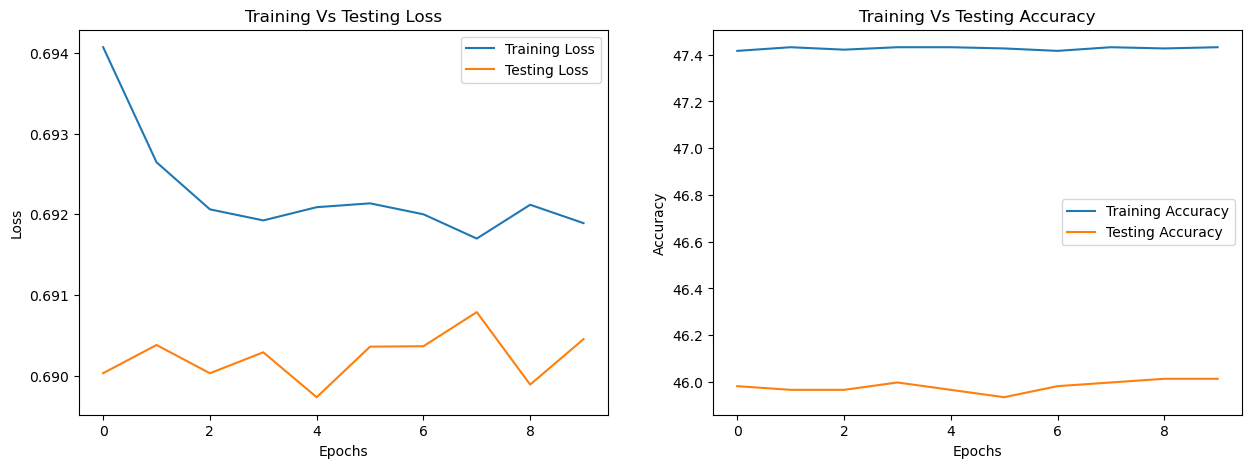

In [119]:
plt.figure(figsize=(15,5))
epochs = range(len(model_0_results['train_loss']))

plt.subplot(1,2,1)
plt.plot(epochs, model_0_results['train_loss'], label='Training Loss')
plt.plot(epochs, model_0_results['test_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Vs Testing Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, model_0_results['train_acc'], label='Training Accuracy')
plt.plot(epochs, model_0_results['test_acc'], label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Vs Testing Accuracy')
plt.legend()

plt.show()